In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f 
from PDE2D import GreenSampling

In [2]:
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 1

In [3]:
green = GreenSampling.Polynomial
use_accel = True

In [4]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 0
def source(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)
f = FunctionCoefficient("f", source_p, source)

In [6]:
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution_image = [256, 256]
spp_image = 256
epsilon = 1e-5

res = 256
spp_boundary = 2 ** 18

radius = 1
computation_radius = 0.8

parameters1 = {}
parameters1["freq"] = 2
parameters1["bias"] = 6
parameters1["scale"] = 12

parameters2 = {}
parameters2["freq"] = 4
parameters2["bias"] = 8
parameters2["scale"] = 16

def boundary_dirichlet(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]

out_val = 1

image = np.array([[0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4]], dtype = np.float64)
image *= 2
image += out_val
dirichlet1 = FunctionCoefficient("dirichlet", parameters1, boundary_dirichlet)
dirichlet2 = FunctionCoefficient("dirichlet", parameters2, boundary_dirichlet)
shape = CircleShape(origin=Point2f(0., 0.), radius=radius, epsilon= epsilon,dirichlet=[dirichlet1, dirichlet2])
α = DiskTextureCoefficient("diffusion", image, radius = radius, constant_thickness= 1.01 - computation_radius, origin = [0,0], out_val = out_val)
#grad_zero_points = shape.create_boundary_points(distance = 0, res = 1024, spp = 2)[0]
#α = TextureCoefficient("diffusion", bbox = bbox, tensor_np = image, out_val=out_val, grad_zero_points=grad_zero_points)

σ = ConstantCoefficient("screening", 2)

data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f)

In [7]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
#data_holder.visualize(ax1, ax2, ax3, ax4)

0 : 16777216 -> 2286893
1 : 2286893 -> 1629392
2 : 1629392 -> 1171089
3 : 1171089 -> 844521
4 : 844521 -> 610183
5 : 610183 -> 440564
6 : 440564 -> 317717
7 : 317717 -> 230303
8 : 230303 -> 166389
9 : 166389 -> 118969
10 : 118969 -> 85165
11 : 85165 -> 61176
12 : 61176 -> 44134
13 : 44134 -> 32114
14 : 32114 -> 23412
15 : 23412 -> 17103
16 : 17103 -> 12400
17 : 12400 -> 9107
18 : 9107 -> 6376
19 : 6376 -> 4686
20 : 4686 -> 3493
21 : 3493 -> 2610
22 : 2610 -> 1875
23 : 1875 -> 1402
24 : 1402 -> 1034
25 : 1034 -> 736
26 : 736 -> 559
27 : 559 -> 424
28 : 424 -> 295
29 : 295 -> 196
30 : 196 -> 150
31 : 150 -> 133
32 : 133 -> 107
33 : 107 -> 73
34 : 73 -> 44
35 : 44 -> 20
36 : 20 -> 13
37 : 13 -> 10
38 : 10 -> 0


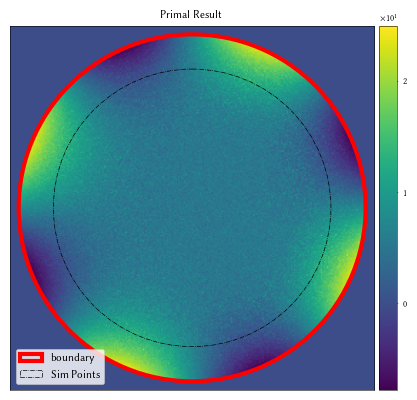

In [8]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WosVariable(data_holder, green_sampling=green, use_accelaration=use_accel)
#print(wos.screened)
L, p = wos.solve(points_in = points, conf_numbers= conf_numbers)
image_0, tensor = create_image_from_result(L, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0[conf_vis], ax1)
ax1.set_title("Primal Result")
shape.sketch(ax1, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax1.add_patch(sphere)
ax1.legend(loc = "lower left", fontsize = 8)

In [9]:

points, _, normal_dir = shape.create_boundary_points(distance=radius - computation_radius, res = res, spp = spp_boundary)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers)
tensor, tensor_mi = shape.create_boundary_result(L, resolution = res)
boundary_dirichlet = shape.create_boundary_coefficient(tensor_mi)

0 : 67108864 -> 4637559
1 : 4637559 -> 3307587
2 : 3307587 -> 2381852
3 : 2381852 -> 1715894
4 : 1715894 -> 1234233
5 : 1234233 -> 888171
6 : 888171 -> 641054
7 : 641054 -> 460750
8 : 460750 -> 333305
9 : 333305 -> 239283
10 : 239283 -> 171599
11 : 171599 -> 123699
12 : 123699 -> 89230
13 : 89230 -> 64582
14 : 64582 -> 46431
15 : 46431 -> 33271
16 : 33271 -> 23970
17 : 23970 -> 17395
18 : 17395 -> 12364
19 : 12364 -> 8978
20 : 8978 -> 6515
21 : 6515 -> 4748
22 : 4748 -> 3412
23 : 3412 -> 2290
24 : 2290 -> 1635
25 : 1635 -> 1170
26 : 1170 -> 869
27 : 869 -> 623
28 : 623 -> 424
29 : 424 -> 295
30 : 295 -> 231
31 : 231 -> 177
32 : 177 -> 116
33 : 116 -> 73
34 : 73 -> 55
35 : 55 -> 44
36 : 44 -> 34
37 : 34 -> 27
38 : 27 -> 21
39 : 21 -> 9
40 : 9 -> 6
41 : 6 -> 0


In [10]:
L, p = wos.solve(points_in = points, derivative_dir = -dr.normalize(points), conf_numbers = conf_numbers)
tensor, tensor_mi = shape.create_boundary_result(L, resolution = res)
boundary_neumann= shape.create_boundary_coefficient(tensor_mi)

0 : 67108864 -> 4905167
1 : 4905167 -> 3498598
2 : 3498598 -> 2518745
3 : 2518745 -> 1816297
4 : 1816297 -> 1313008
5 : 1313008 -> 948101
6 : 948101 -> 683652
7 : 683652 -> 493860
8 : 493860 -> 355590
9 : 355590 -> 256258
10 : 256258 -> 184628
11 : 184628 -> 132797
12 : 132797 -> 96241
13 : 96241 -> 69467
14 : 69467 -> 49768
15 : 49768 -> 36353
16 : 36353 -> 26173
17 : 26173 -> 18892
18 : 18892 -> 13264
19 : 13264 -> 9455
20 : 9455 -> 6815
21 : 6815 -> 5016
22 : 5016 -> 3750
23 : 3750 -> 2716
24 : 2716 -> 2062
25 : 2062 -> 1489
26 : 1489 -> 1152
27 : 1152 -> 780
28 : 780 -> 532
29 : 532 -> 399
30 : 399 -> 310
31 : 310 -> 252
32 : 252 -> 156
33 : 156 -> 121
34 : 121 -> 92
35 : 92 -> 79
36 : 79 -> 75
37 : 75 -> 49
38 : 49 -> 43
39 : 43 -> 31
40 : 31 -> 19
41 : 19 -> 11
42 : 11 -> 8
43 : 8 -> 0


Text(0.5, 1.0, 'Dirichlet Cut')

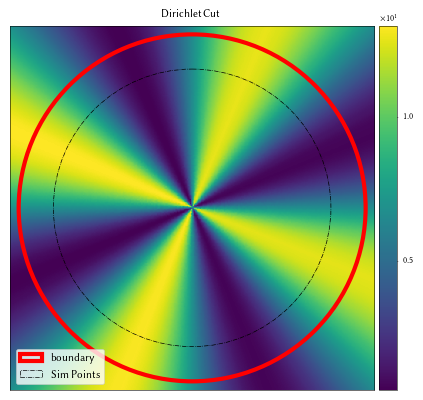

In [11]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc = "lower left", fontsize = 8)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

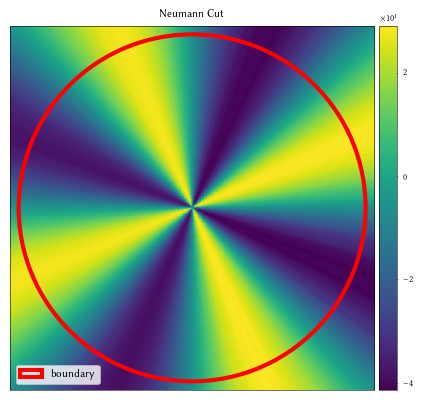

In [12]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
ax.set_title("Neumann Cut")

In [14]:
angle_partition1 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([1, 0, 1, 0])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([0, 1, 1, 1])
shape1 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
data_holder1 = DataHolder(shape = shape1, σ=σ, f=f, α = α)

shape2 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
data_holder2 = DataHolder(shape = shape2, σ=σ, f=f, α = α)

In [15]:
bbox_ = [[-1.05 * computation_radius, -1.05 * computation_radius], [1.05 * computation_radius, 1.05 * computation_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostVariable(data_holder1, green_sampling = green, use_accelaration = use_accel)
L1, _ = wos1.solve(points_in = points, conf_numbers=conf_numbers)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostVariable(data_holder2, green_sampling = green, use_accelaration=use_accel)
L2, _ = wos2.solve(points_in = points, conf_numbers = conf_numbers)
image2, tensor = create_image_from_result(L2, resolution_image)

0 : 16777216 -> 2998720
1 : 2998720 -> 2034085
2 : 2034085 -> 1390453
3 : 1390453 -> 952546
4 : 952546 -> 655630
5 : 655630 -> 450143
6 : 450143 -> 308162
7 : 308162 -> 212521
8 : 212521 -> 145044
9 : 145044 -> 99697
10 : 99697 -> 68222
11 : 68222 -> 46901
12 : 46901 -> 32329
13 : 32329 -> 21999
14 : 21999 -> 15010
15 : 15010 -> 10242
16 : 10242 -> 7038
17 : 7038 -> 4864
18 : 4864 -> 3412
19 : 3412 -> 2297
20 : 2297 -> 1521
21 : 1521 -> 987
22 : 987 -> 715
23 : 715 -> 435
24 : 435 -> 279
25 : 279 -> 165
26 : 165 -> 105
27 : 105 -> 65
28 : 65 -> 45
29 : 45 -> 40
30 : 40 -> 35
31 : 35 -> 20
32 : 20 -> 10
33 : 10 -> 5
34 : 5 -> 3
35 : 3 -> 4
36 : 4 -> 3
37 : 3 -> 1
38 : 1 -> 1
39 : 1 -> 1
40 : 1 -> 0
0 : 16777216 -> 3449116
1 : 3449116 -> 2567109
2 : 2567109 -> 1931150
3 : 1931150 -> 1457593
4 : 1457593 -> 1097784
5 : 1097784 -> 827554
6 : 827554 -> 625063
7 : 625063 -> 470998
8 : 470998 -> 356550
9 : 356550 -> 268492
10 : 268492 -> 203451
11 : 203451 -> 154121
12 : 154121 -> 115998
13 : 

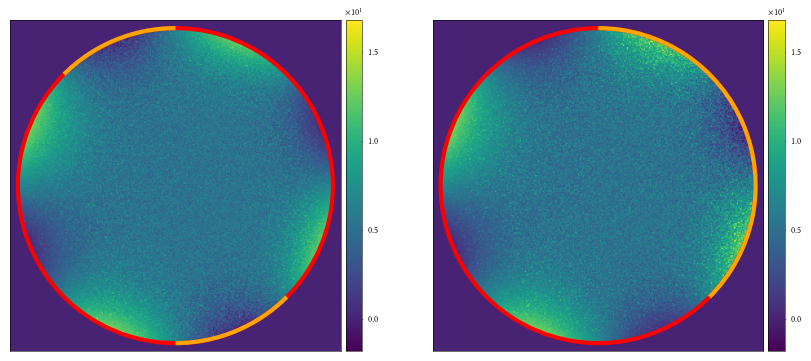

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
max_val = max(image1[conf_vis].max(), image2[conf_vis].max())
min_val = min(image1[conf_vis].min(), image2[conf_vis].min())
range_ = [min_val, max_val]
plot_image(image1[conf_vis], ax1, input_range=range_)
shape1.sketch(ax1, bbox_, resolution_image)
plot_image(image2[conf_vis], ax2, input_range=range_)
shape2.sketch(ax2, bbox_, resolution_image)

Mean:
-0.00259463
Variance:
0.8527517


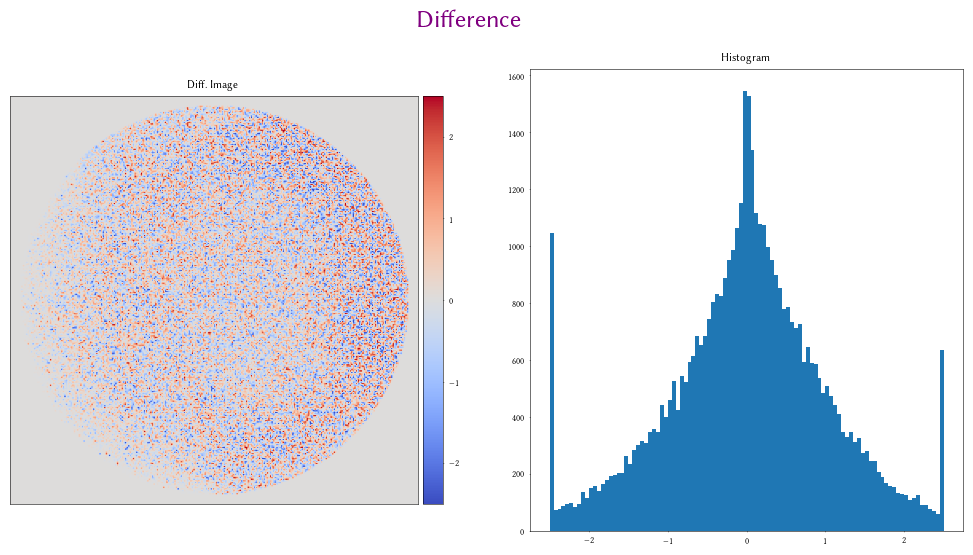

In [17]:
sketch_diff(image1[conf_vis], image2[conf_vis], max_range = 2.5)